In [204]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline

In [205]:
# loading train dataset
train_csv = pd.read_csv('../input/application_train.csv.zip', compression='infer')

In [206]:
# removing 5 rows
train_csv = train_csv[train_csv['NAME_INCOME_TYPE'] != 'Maternity leave']

# removing 4 rows
train_csv = train_csv[train_csv['NAME_FAMILY_STATUS'] != 'Unknown']

# removing 2 rows
train_csv = train_csv[train_csv['CODE_GENDER'] != 'XNA']

In [207]:
# loading history data
installments = pd.read_csv('../input/installments_payments.csv.zip', compression='infer')
previous = pd.read_csv('../input/previous_application.csv.zip', compression='infer')
bureau = pd.read_csv('../input/bureau.csv.zip', compression='infer')

In [208]:
# loading balance data
credit_card_balance = pd.read_csv('../input/credit_card_balance.csv.zip', compression='infer')
#bureau_balance = pd.read_csv('../input/bureau_balance.csv.zip', compression='infer')
cash_balance = pd.read_csv('../input/POS_CASH_balance.csv.zip', compression='infer')

In [209]:
def aggregate_df(df, value, func, labels, by='SK_ID_CURR', column=None):
    
    if column != None:
        pivoted = df.pivot_table(index=by, 
                                 columns=column, 
                                 values=value, 
                                 aggfunc=func, 
                                 fill_value=0, 
                                 dropna=False)
    else:
        pivoted = df.pivot_table(index=by, 
                                 values=value, 
                                 aggfunc=func, 
                                 fill_value=0, 
                                 dropna=False)
        
    pivoted_df = pd.DataFrame(pivoted.to_records())
    
    pivoted_df.rename(columns=labels, inplace=True)
    
    return pivoted_df

In [210]:
X = train_csv
X.set_index('SK_ID_CURR',inplace=True)

In [211]:
labels = {
          'Active'   : 'CNT_ACTIVE_LOANS',
          'Bad debt' : 'CNT_BAD_DEBT',
          'Closed'   : 'CNT_CLOSED_DEBT',
          'Sold'     : 'CNT_SOLD_DEBT'
         }

cnt_loans = aggregate_df(df=bureau, value='CREDIT_TYPE', column='CREDIT_ACTIVE', func='count', labels=labels)

labels = {
          'Active'   : 'AMT_ACTIVE_LOANS',
          'Bad debt' : 'AMT_BAD_DEBT',
          'Closed'   : 'AMT_CLOSED_DEBT',
          'Sold'     : 'AMT_SOLD_DEBT'
         }

amt_loans = aggregate_df(df=bureau, value='AMT_CREDIT_SUM', column='CREDIT_ACTIVE', func='sum', labels=labels)

labels = {
          'OVERDUE'   : 'MAX_OVERDUE'
         }

installments['OVERDUE'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
max_overdue = aggregate_df(df=installments, value='OVERDUE', func='max', labels=labels)

labels = {
          'CNT_INSTALMENT_FUTURE'   : 'CNT_FUTURE_INSTALLMENTS'
         }

cnt_future_installments = aggregate_df(df=cash_balance, value='CNT_INSTALMENT_FUTURE', func='sum', labels=labels)

labels = {
          'Approved'     : 'CNT_LOANS_APPROVED',
          'Canceled'     : 'CNT_LOANS_CANCELLED',
          'Refused'      : 'CNT_LOANS_REFUSED',
          'Unused offer' : 'CNT_UNUSED_OFFERS'
         }

cnt_prev_loans = aggregate_df(df=previous, 
                              value='NAME_CONTRACT_TYPE', column='NAME_CONTRACT_STATUS', func='count', labels=labels)

labels = {
          'CNT_DRAWINGS_CURRENT'   : 'CNT_CC_DRAWINGS'
         }

cc_draw_cnt = aggregate_df(df=credit_card_balance,
                          value='CNT_DRAWINGS_CURRENT', func='sum', labels=labels)

cc_balance = pd.DataFrame(credit_card_balance.pivot_table(index='SK_ID_CURR', 
                                             values=['AMT_PAYMENT_TOTAL_CURRENT'], 
                                             columns='MONTHS_BALANCE',
                                             aggfunc='mean').to_records())[['SK_ID_CURR',"('AMT_PAYMENT_TOTAL_CURRENT', -1)"]]

cc_balance.columns = ['SK_ID_CURR', 'CREDIT_CARD_BALANCE']

X = pd.concat([X, cnt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, amt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, max_overdue], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_future_installments], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_prev_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_draw_cnt], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_balance], axis=1, join='outer', join_axes=[X.index])

del cnt_loans, amt_loans, max_overdue, cnt_future_installments, cnt_prev_loans, cc_balance, cc_draw_cnt
del previous, cash_balance, installments, bureau, credit_card_balance

In [212]:
# assigning X,y
y = X['TARGET']
X = pd.get_dummies(X.drop(['TARGET','SK_ID_CURR'], axis=1), dummy_na=True)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [214]:
gboost_baseline = GradientBoostingClassifier(n_estimators=200)

In [215]:
gboost_baseline.fit(X_train.fillna(value=0), y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [216]:
predictions = gboost_baseline.predict(X_test.fillna(0))
pred_prob = gboost_baseline.predict_proba(X_test.fillna(0))

In [217]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     93220
          1       0.51      0.02      0.03      8255

avg / total       0.89      0.92      0.88    101475



In [218]:
print(confusion_matrix(y_test, predictions))

[[93083   137]
 [ 8112   143]]


In [219]:
roc_auc_score(y_test, pred_prob[:,1])

0.7532305088124444

In [220]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])

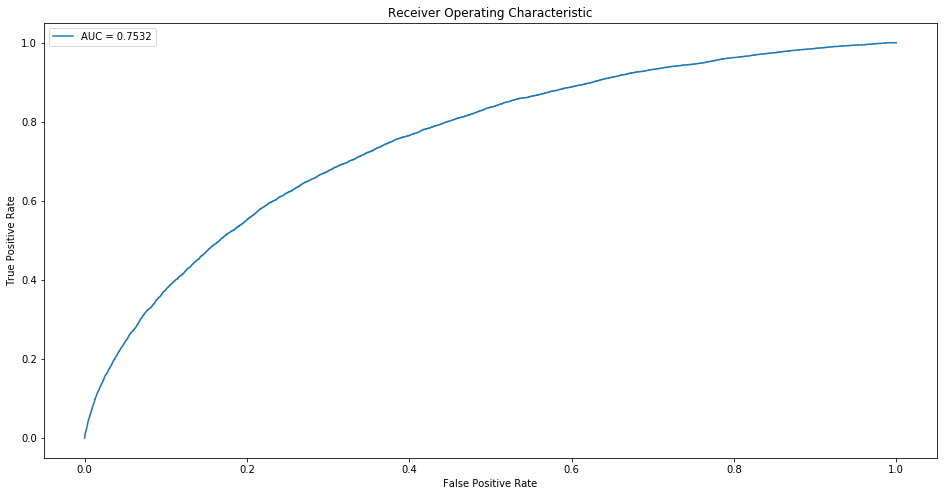

In [221]:
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC = %0.4f'% roc_auc_score(y_test, pred_prob[:,1]))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='upper left')

In [222]:
summary = pd.Series(gboost_baseline.feature_importances_)
summary.index = X.columns

In [223]:
summary.sort_values(ascending=False, inplace=True)

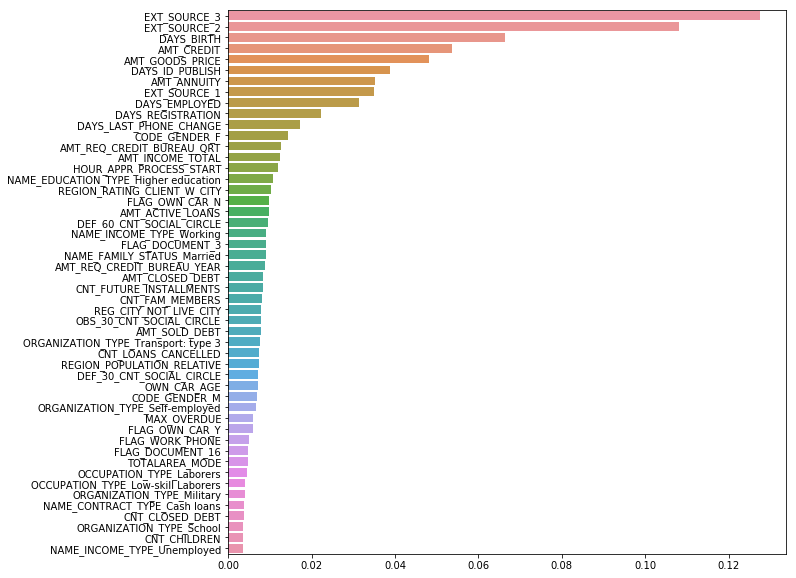

In [224]:
plt.figure(figsize=(10,10))
sns.barplot(y=summary[:50].index.values, x=summary[:50].values)

In [225]:
test_csv.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
test_csv = pd.read_csv('../input/application_test.csv.zip', compression='infer')

In [227]:
X = test_csv
X.set_index('SK_ID_CURR',inplace=True)

In [228]:
# loading history data
installments = pd.read_csv('../input/installments_payments.csv.zip', compression='infer')
previous = pd.read_csv('../input/previous_application.csv.zip', compression='infer')
bureau = pd.read_csv('../input/bureau.csv.zip', compression='infer')

# loading balance data
credit_card_balance = pd.read_csv('../input/credit_card_balance.csv.zip', compression='infer')
#bureau_balance = pd.read_csv('../input/bureau_balance.csv.zip', compression='infer')
cash_balance = pd.read_csv('../input/POS_CASH_balance.csv.zip', compression='infer')

In [229]:
labels = {
          'Active'   : 'CNT_ACTIVE_LOANS',
          'Bad debt' : 'CNT_BAD_DEBT',
          'Closed'   : 'CNT_CLOSED_DEBT',
          'Sold'     : 'CNT_SOLD_DEBT'
         }

cnt_loans = aggregate_df(df=bureau, value='CREDIT_TYPE', column='CREDIT_ACTIVE', func='count', labels=labels)

labels = {
          'Active'   : 'AMT_ACTIVE_LOANS',
          'Bad debt' : 'AMT_BAD_DEBT',
          'Closed'   : 'AMT_CLOSED_DEBT',
          'Sold'     : 'AMT_SOLD_DEBT'
         }

amt_loans = aggregate_df(df=bureau, value='AMT_CREDIT_SUM', column='CREDIT_ACTIVE', func='sum', labels=labels)

labels = {
          'OVERDUE'   : 'MAX_OVERDUE'
         }

installments['OVERDUE'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
max_overdue = aggregate_df(df=installments, value='OVERDUE', func='max', labels=labels)

labels = {
          'CNT_INSTALMENT_FUTURE'   : 'CNT_FUTURE_INSTALLMENTS'
         }

cnt_future_installments = aggregate_df(df=cash_balance, value='CNT_INSTALMENT_FUTURE', func='sum', labels=labels)

labels = {
          'Approved'     : 'CNT_LOANS_APPROVED',
          'Canceled'     : 'CNT_LOANS_CANCELLED',
          'Refused'      : 'CNT_LOANS_REFUSED',
          'Unused offer' : 'CNT_UNUSED_OFFERS'
         }

cnt_prev_loans = aggregate_df(df=previous, 
                              value='NAME_CONTRACT_TYPE', column='NAME_CONTRACT_STATUS', func='count', labels=labels)

labels = {
          'CNT_DRAWINGS_CURRENT'   : 'CNT_CC_DRAWINGS'
         }

cc_draw_cnt = aggregate_df(df=credit_card_balance,
                          value='CNT_DRAWINGS_CURRENT', func='sum', labels=labels)

cc_balance = pd.DataFrame(credit_card_balance.pivot_table(index='SK_ID_CURR', 
                                             values=['AMT_PAYMENT_TOTAL_CURRENT'], 
                                             columns='MONTHS_BALANCE',
                                             aggfunc='mean').to_records())[['SK_ID_CURR',"('AMT_PAYMENT_TOTAL_CURRENT', -1)"]]

cc_balance.columns = ['SK_ID_CURR', 'CREDIT_CARD_BALANCE']

X = pd.concat([X, cnt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, amt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, max_overdue], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_future_installments], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_prev_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_draw_cnt], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_balance], axis=1, join='outer', join_axes=[X.index])

del cnt_loans, amt_loans, max_overdue, cnt_future_installments, cnt_prev_loans, cc_balance, cc_draw_cnt
del previous, cash_balance, installments, bureau, credit_card_balance

In [230]:
X = pd.get_dummies(X.drop(['SK_ID_CURR'], axis=1), dummy_na=True)

In [231]:
probs = gboost_baseline.predict_proba(X.fillna(0))

In [232]:
submission = pd.DataFrame()
submission['TARGET'] = probs[:,1]
submission.index = test_csv.index

In [233]:
submission.to_csv('gboost-feature-engineering-2000.csv')